In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import optuna
import plotly.express as px
import plotly.graph_objects as go
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PathCollection
from matplotlib.colorbar import Colorbar
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_validate as cv
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from xgboost import XGBClassifier
from tpot import TPOTClassifier
from IPython.display import Image
from seaborn import FacetGrid
from itertools import cycle

warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Multi-Class Prediction of Obesity Risk

The dataset (both train and test) was generated from a deep learning model trained on the Obesity or CVD risk dataset. Feature distributions are close to, but not exactly the same.The  is to use various factors to predict obesity risk in individuals, which is related to cardiovascular disease.

Type
csv

License
Attribution 4.0 International (CC BY 4.0)

Source: https://www.kaggle.com/competitions/playground-series-s4e2/


In [5]:
# Load the data
df = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
df.info()
df.isnull().sum()
df.describe()
df.duplicated().sum()
df = df.drop_duplicates()
df.describe(include="all")


def get_unique_values(data):
    unique_values = {}
    for column in data.columns:
        unique_values[column] = data[column].value_counts().head(10).index.tolist()
    return unique_values


unique_values = get_unique_values(df)
for column, values in unique_values.items():
    print(f"Unique values of {column}: {values}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

The dataset includes detailed profiling of 20,758 individuals, reflecting a broad range of lifestyle and health metrics. It provides several insights and assumptions about obesity and its influencing factors. Here's a closer look at the potential insights and underlying assumptions that can be drawn from the data:

### Insights:

- Prevalence of Family History in Overweight Cases: A significant portion of participants reported a family history of overweight. This suggests a strong genetic or environmental component in obesity. Families may share not only genes but also dietary habits and lifestyle practices, highlighting the intertwined nature of genetics and environment in obesity risk.

- Dietary Habits and Obesity: The high frequency of participants consuming calorie-dense foods, coupled with their vegetable intake patterns, highlights the pivotal role of diet in obesity. The dataset provides a foundation for examining how specific dietary choices correlate with obesity levels, potentially guiding nutritional interventions.

- Physical Activity and Sedentary Lifestyle: Given the quantified data on physical activity frequency and time spent using electronic devices, there's an avenue to investigate the balance between active and sedentary behaviors among the participants. This balance is crucial as sedentary lifestyles have been linked to increased obesity risk, independent of physical exercise levels.

- Hydration and Health: The inclusion of daily water consumption data allows for an examination of hydration habits in relation to weight and overall health. Proper hydration is often associated with better metabolic health and weight management, suggesting a possible area for intervention.

- Impact of Smoking and Alcohol Consumption: While less directly related to obesity, smoking, and alcohol consumption patterns offer a lens into overall lifestyle choices that can influence health. These factors could be indirectly related to obesity through their impact on metabolism, appetite, and physical activity levels.

### Assumptions:

- Socioeconomic and Cultural Factors: The dataset likely encompasses a wide range of socioeconomic backgrounds and cultural contexts, given the diversity in dietary habits, physical activity, and modes of transportation.

- Accuracy of Self-Reported Data: Assuming the dataset is based on self-reported information, there's an inherent assumption about the accuracy and reliability of the data. Participants may underreport or overreport certain behaviors, such as dietary intake or physical activity, which could affect the analysis.

- Static Snapshot of Behaviors: The dataset provides a static snapshot of behaviors and health statuses, assuming these factors are consistent over time. In reality, individuals' diets, activity levels, and even obesity status can fluctuate.

- Generalization to Broader Populations: Given the specific sample size and composition, there may be an assumption that findings from this dataset can be generalized to broader populations. However, demographic and cultural differences could limit the applicability of insights to other groups.

- Causation vs. Correlation: The dataset enables the identification of correlations between various factors and obesity. However, it's essential to remember that correlation does not necessarily imply causation. Further research is necessary to establish causal relationships.

# Exploratory data analysis

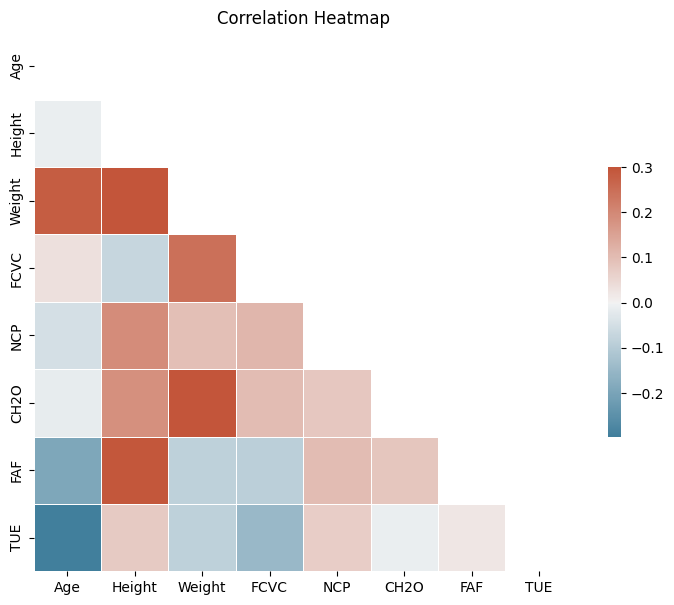

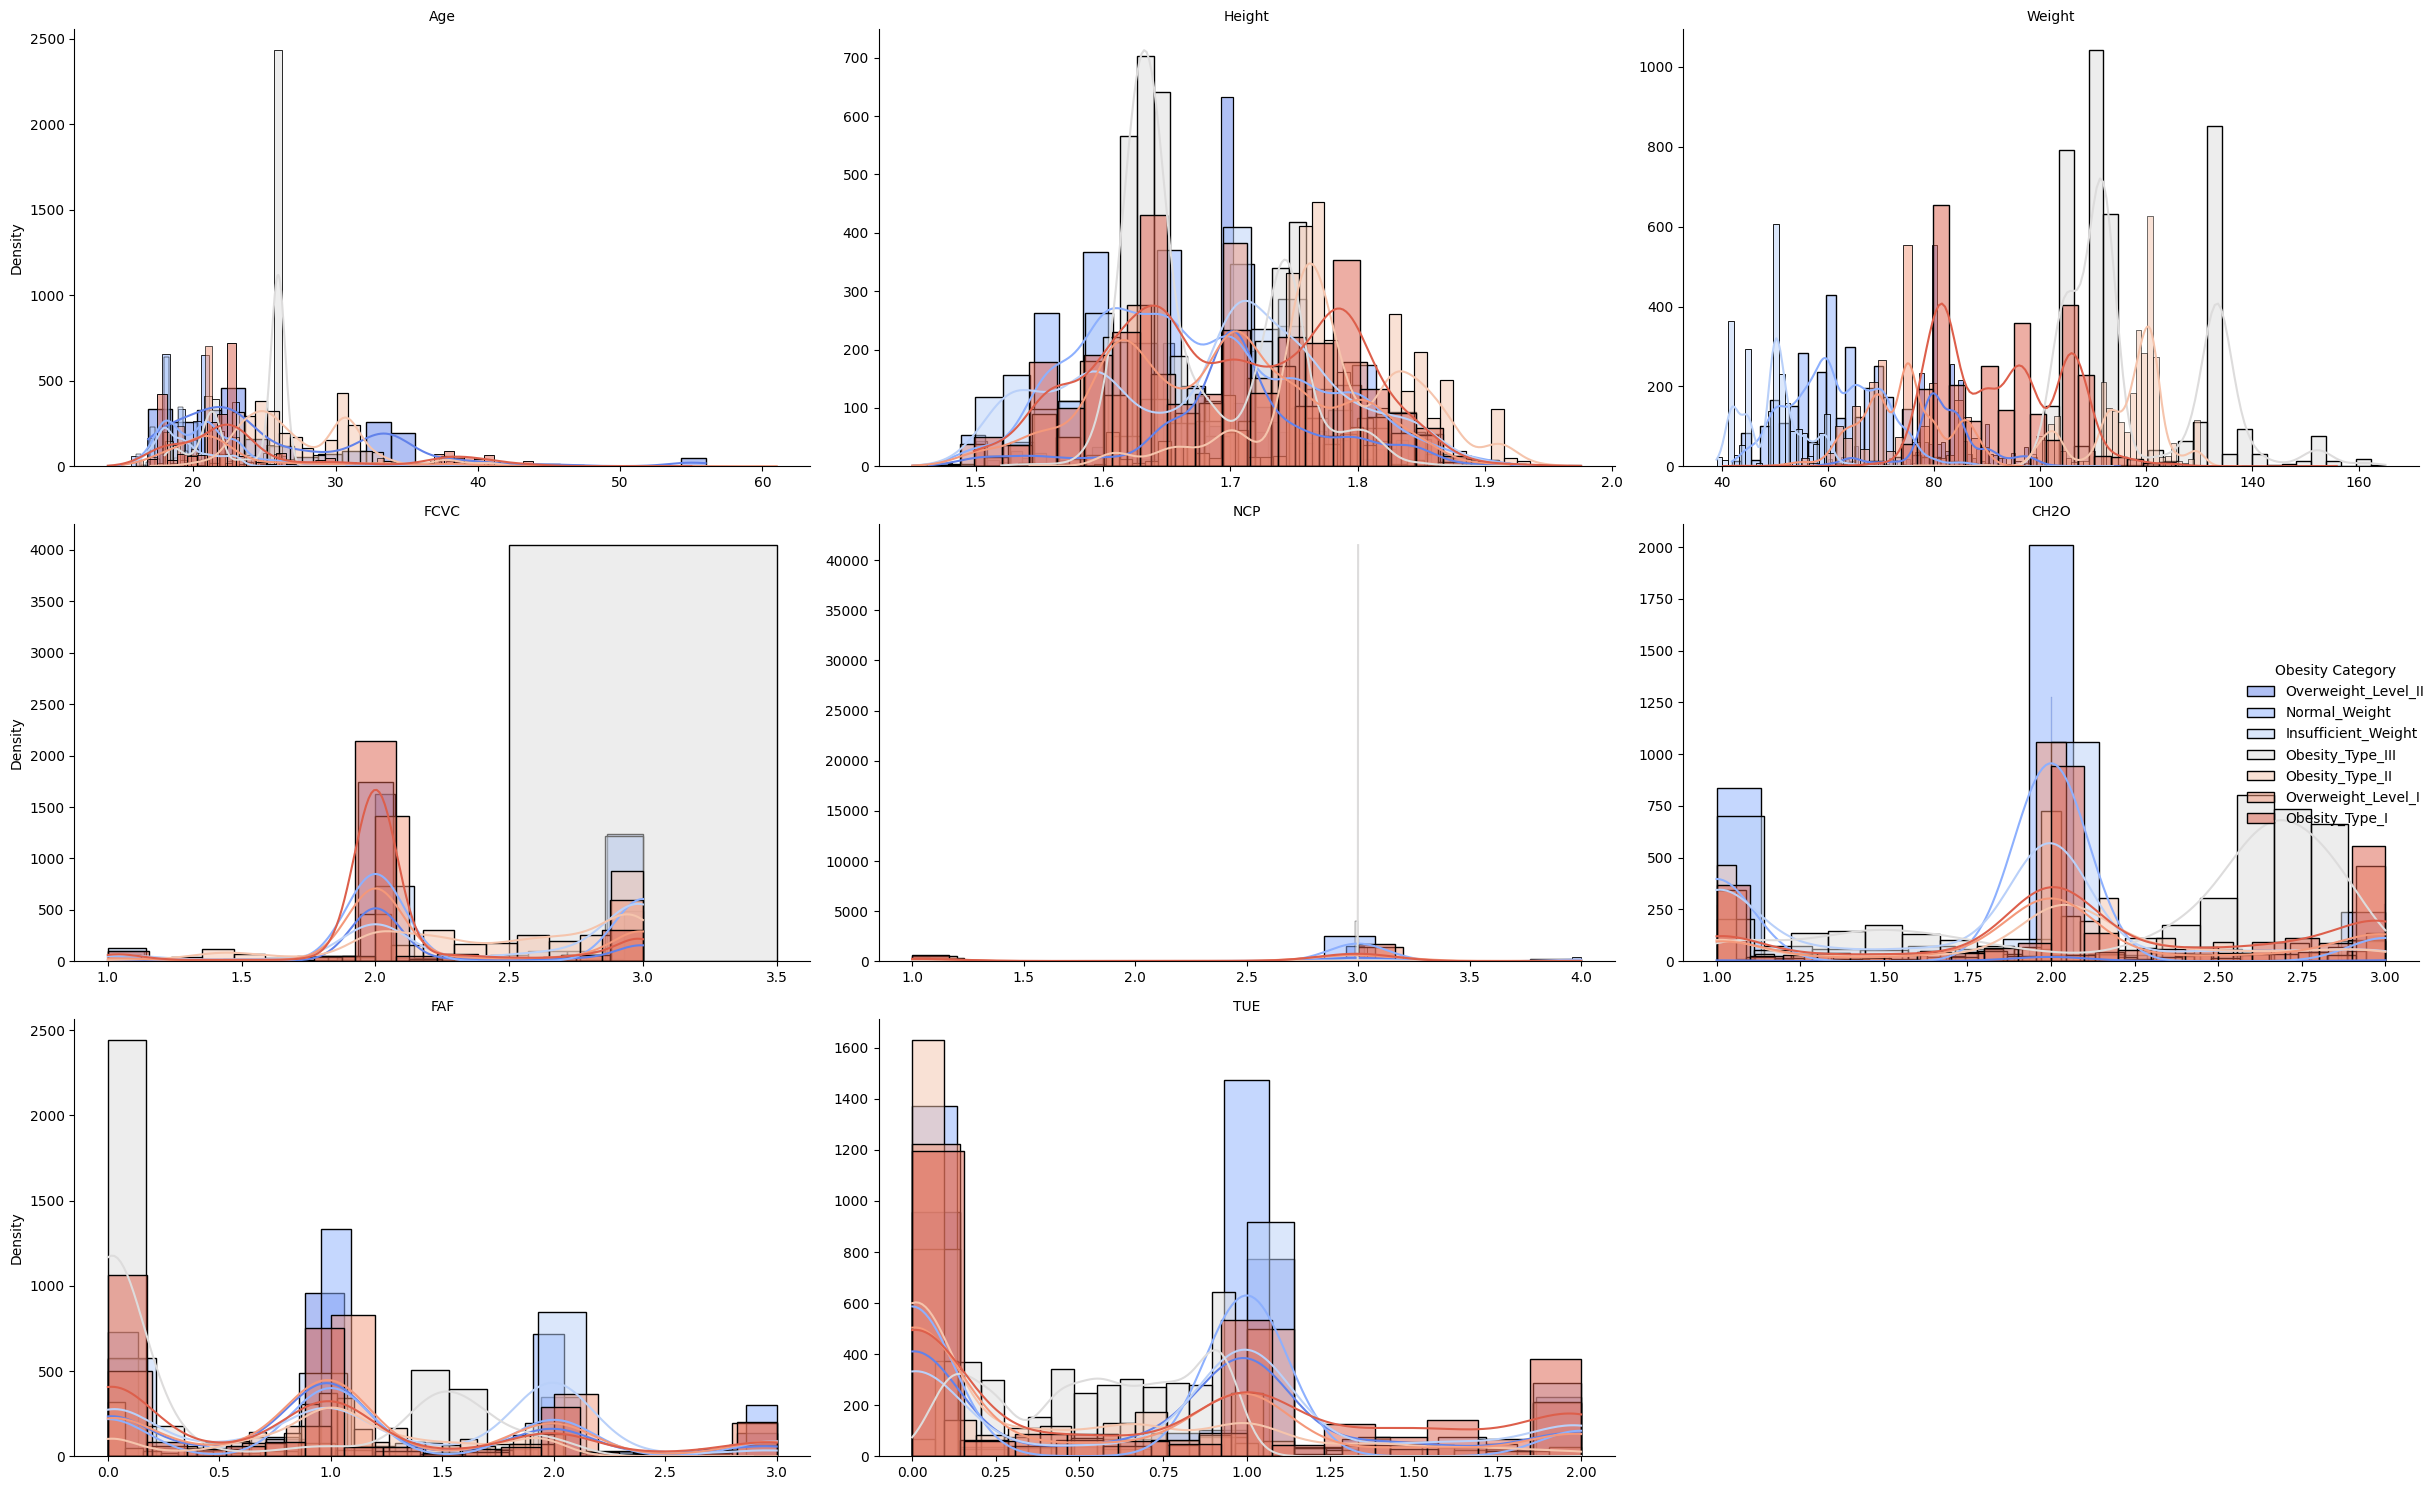

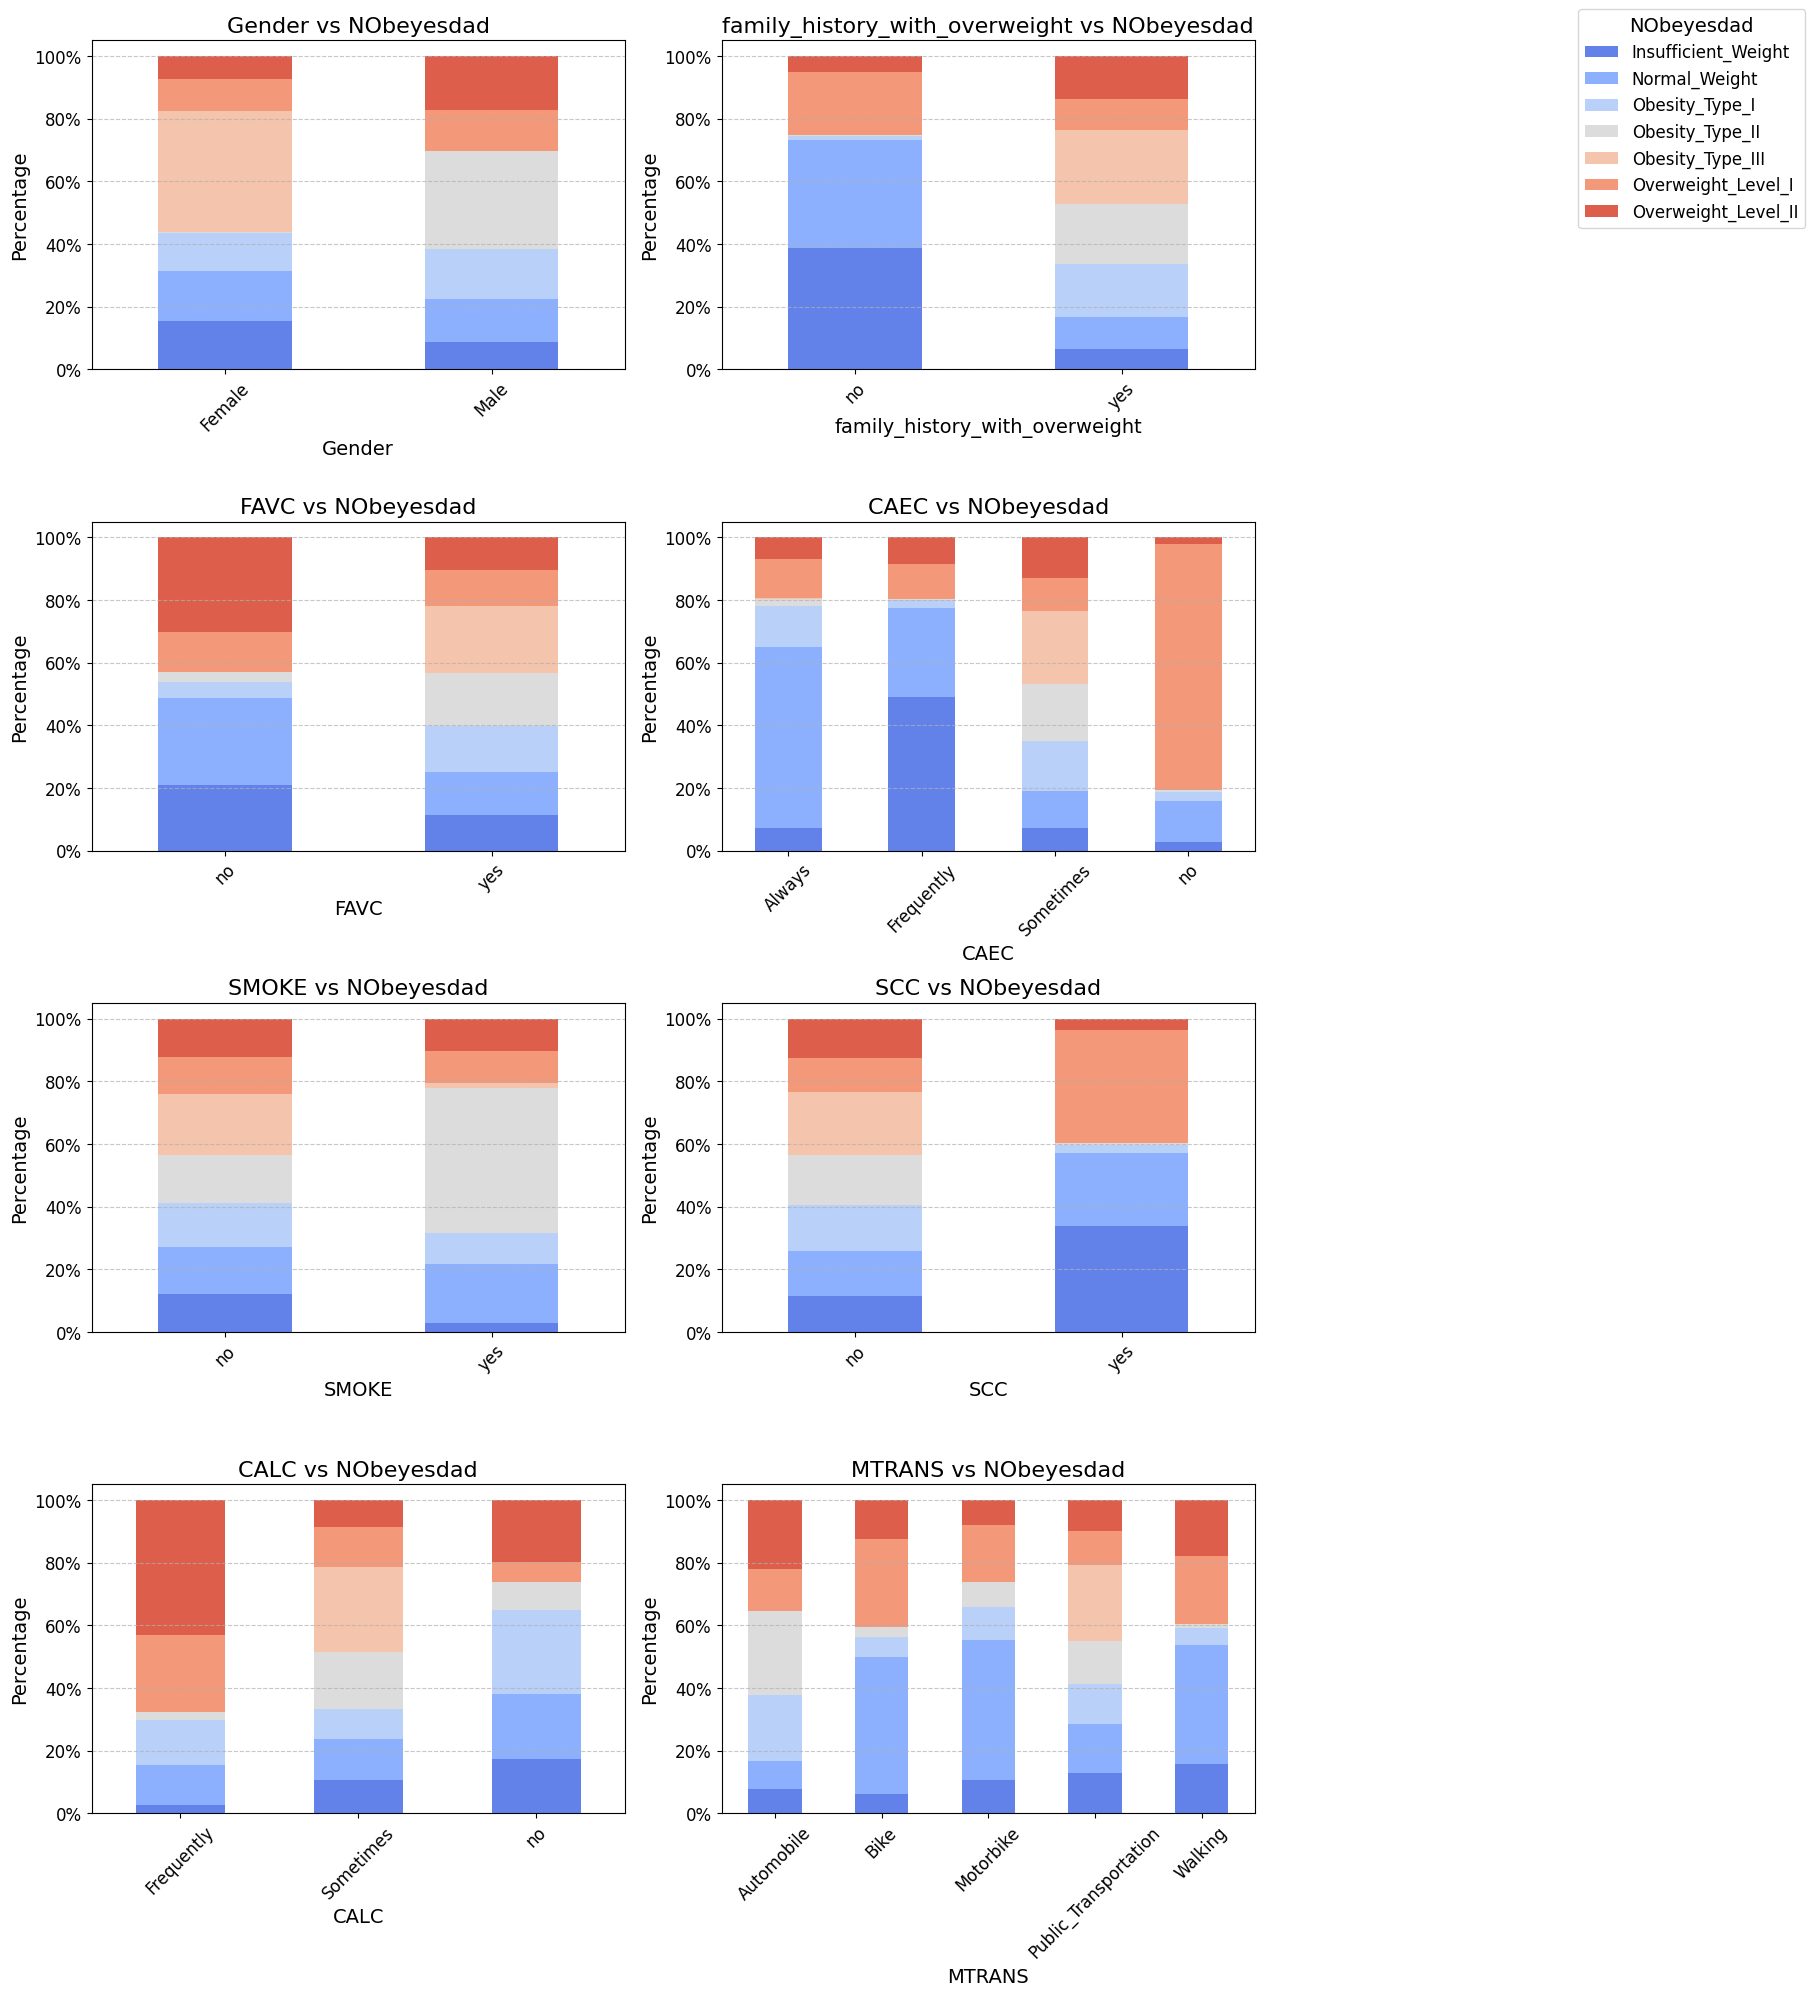

In [6]:

# Initialize the list of numerical columns for analysis.
numerical = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

correlation = df[numerical].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig, ax = plt.subplots(figsize=(9, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    correlation,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
)
plt.title("Correlation Heatmap")

# Convert the dataframe to a long format suitable for FacetGrid plotting.
df_long = df.melt(
    id_vars="NObeyesdad", value_vars=numerical, var_name="Feature", value_name="Value"
)

# Generate a FacetGrid of histograms for each feature, segmented by obesity category.
g = sns.FacetGrid(
    df_long,
    col="Feature",
    col_wrap=3,
    sharex=False,
    sharey=False,
    hue="NObeyesdad",
    height=5,
    aspect=1.5,
    palette="coolwarm",
)
g.map(sns.histplot, "Value", kde=True, stat="count", common_norm=False)

# Integrate a legend to identify obesity categories.
g.add_legend(title="Obesity Category")

# Fine-tune the plot titles and axes labels.
g.set_titles("{col_name}")
g.set_axis_labels("", "Density")

plt.tight_layout()
plt.show()

# Define categorical variables for analysis.
categorical = [
    "Gender",
    "family_history_with_overweight",
    "FAVC",
    "CAEC",
    "SMOKE",
    "SCC",
    "CALC",
    "MTRANS",
]

# Adjust subplot layout to accommodate the number of categorical variables.
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Set color palette based on the unique categories of obesity.
palette = sns.color_palette("coolwarm", len(df["NObeyesdad"].unique()))

# Plot each categorical variable against the obesity categories.
for i, column in enumerate(categorical):
    ax = axes[i // 2, i % 2]
    data = (
        df.groupby([column, "NObeyesdad"])
        .size()
        .unstack()
        .apply(lambda x: x / x.sum() * 100, axis=1)
    )
    bars = data.plot(kind="bar", stacked=True, ax=ax, color=palette, legend=False)

    # Set plot aesthetics.
    ax.set_title(f"{column} vs NObeyesdad", fontsize=16)
    ax.set_ylabel("Percentage", fontsize=14)
    ax.set_xlabel(column, fontsize=14)
    ax.tick_params(axis="x", rotation=45)
    ax.tick_params(axis="both", which="major", labelsize=12)

    # Format y-axis labels.
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0f}%"))
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Create a unified legend for all subplots.
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="NObeyesdad",
    fontsize=12,
    title_fontsize=14,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

# Display the plots with adjusted layout.
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

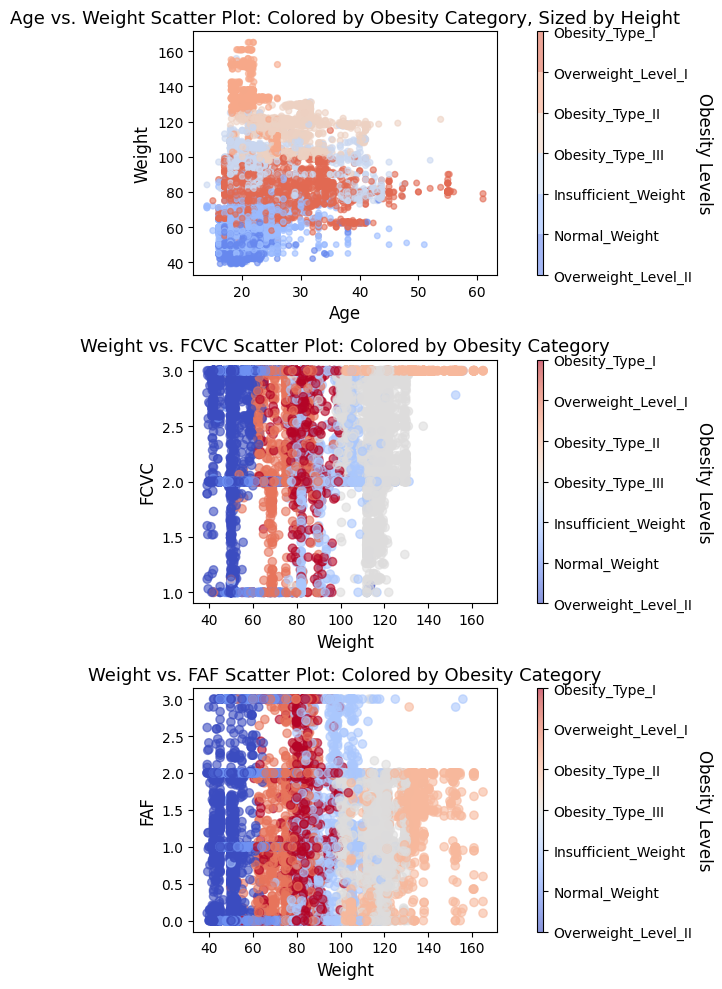

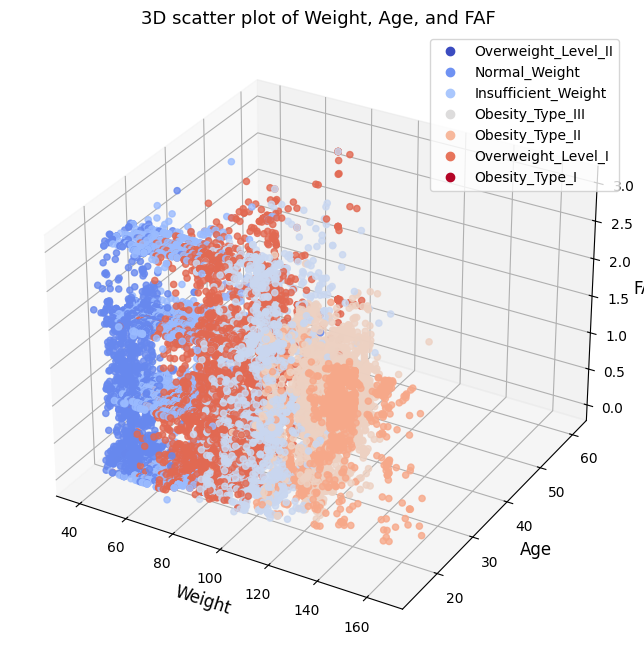

In [7]:
cmap = ListedColormap(sns.color_palette("coolwarm"))

legend_labels = df["NObeyesdad"].unique()

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

# Generate a scatter plot of Age versus Weight with color coding by obesity category and size by height.
scatter_age_weight = axs[0].scatter(
    df["Age"],
    df["Weight"],
    alpha=0.6,
    c=df["NObeyesdad"].astype("category").cat.codes,
    cmap=cmap,
    s=df["Height"] * 10,
)
axs[0].set_title(
    "Age vs. Weight Scatter Plot: Colored by Obesity Category, Sized by Height",
    fontsize=13,
)
axs[0].set_xlabel("Age", fontsize=12)
axs[0].set_ylabel("Weight", fontsize=12)
cbar_age_weight = plt.colorbar(scatter_age_weight, ax=axs[0], aspect=40, pad=0.1)
cbar_age_weight.set_label("Obesity Levels", rotation=270, labelpad=15, fontsize=12)
cbar_age_weight.set_ticks(list(range(len(legend_labels))))
cbar_age_weight.set_ticklabels(legend_labels)

# Generate a scatter plot of Weight versus FCVC (Frequency of Consuming Vegetables), color-coded by obesity category.
scatter_fcvc = axs[1].scatter(
    df["Weight"],
    df["FCVC"],
    alpha=0.6,
    c=df["NObeyesdad"].astype("category").cat.codes,
    cmap="coolwarm",
)
axs[1].set_title(
    "Weight vs. FCVC Scatter Plot: Colored by Obesity Category", fontsize=13
)
axs[1].set_xlabel("Weight", fontsize=12)
axs[1].set_ylabel("FCVC", fontsize=12)
cbar_fcvc = plt.colorbar(scatter_fcvc, ax=axs[1], aspect=40, pad=0.1)
cbar_fcvc.set_label("Obesity Levels", rotation=270, labelpad=15, fontsize=12)
cbar_fcvc.set_ticks(list(range(len(legend_labels))))
cbar_fcvc.set_ticklabels(legend_labels)

# Generate a scatter plot of Weight versus FAF (Physical Activity Frequency), color-coded by obesity category.
scatter_faf = axs[2].scatter(
    df["Weight"],
    df["FAF"],
    alpha=0.6,
    c=df["NObeyesdad"].astype("category").cat.codes,
    cmap="coolwarm",
)
axs[2].set_title(
    "Weight vs. FAF Scatter Plot: Colored by Obesity Category", fontsize=13
)
axs[2].set_xlabel("Weight", fontsize=12)
axs[2].set_ylabel("FAF", fontsize=12)
cbar_faf = plt.colorbar(scatter_faf, ax=axs[2], aspect=40, pad=0.1)
cbar_faf.set_label("Obesity Levels", rotation=270, labelpad=15, fontsize=12)
cbar_faf.set_ticks(list(range(len(legend_labels))))
cbar_faf.set_ticklabels(legend_labels)

plt.tight_layout()
plt.show()

# Generate a color mapping dictionary for clearly visualizing obesity levels.
categories = df["NObeyesdad"].unique().tolist()
colors = [plt.cm.coolwarm(i / float(len(categories) - 1)) for i in range(len(categories))]
color_dict = dict(zip(categories, colors))

# Construct a 3D scatter plot to demonstrate the relationship among Weight, Age, and Physical Activity Frequency (FAF).
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    df["Weight"],
    df["Age"],
    df["FAF"],
    c=df["NObeyesdad"].astype("category").cat.codes,
    cmap=cmap,
    alpha=0.8,
    linewidth=1,
)

# Enhance the readability of plot's labels and title.
ax.set_xlabel("Weight", fontsize=12)
ax.set_ylabel("Age", fontsize=12)
ax.set_zlabel("FAF", fontsize=12)
plt.title("3D scatter plot of Weight, Age, and FAF", fontsize=13)

# Create a custom legend for ease of interpretation.
markers = [
    plt.Line2D([0, 0], [0, 0], color=color, marker="o", linestyle="")
    for color in color_dict.values()
]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

# Feature engineering


Enhancing the predictive power of learning algorithms.
Allowing algorithms to uncover insights from the data that might not be immediately apparent.
Improving model accuracy by providing additional context.
Potentially reducing the need for complex modeling techniques if meaningful features are constructed.
The approach I took in my recommendation for your project includes creating and transforming variables:

BMI (Body Mass Index) Calculation: A mathematical transformation using weight and height to ascertain obesity levels, which are relevant health indicators.

Age Grouping: Binning ages into groups to capture life-stage-specific patterns that might affect other variables in different ways.

Normalization: Scaling frequency-related features so that they can be compared on the same scale. This avoids features with larger scales disproportionately influencing the model.

Composite Score Creation: Combining related behaviors (like physical activity levels and screen time) to create a single measure that may have a compound effect on the outcome.

Tendency Evaluation: Assessing habits, such as caloric intake and snacking tendency, through direct questions and indirect measures like normalized frequencies to better understand eating patterns.

Scoring System: Assigning numerical values to categorical data to reflect ordered relationships and potential impacts on health.

Mapping and Encoding: Transforming categorical variables like transportation methods into numerical scores that reflect their relationship with physical activity.

And some random indexis

In [8]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')

In [9]:
def feature_engineering(df):
    # Calculates log-transformed Body Mass Index (BMI) for better normalization of data.
    df["log_BMI"] = np.log(df["Weight"] / (df["Height"] ** 2) + 1e-6)

    # Categorizes individuals into age groups to identify age-related trends.
    df["age_group"] = pd.cut(
        df["Age"],
        bins=[0, 18, 30, 40, 50, 60, np.inf],
        labels=["<18", "18-30", "30-40", "40-50", "50-60", "60+"],
    )

    # Computes a physical activity score to quantify participants' physical activity levels.
    df["physical_activity_score"] = df["FAF"] * 2 + (1 - df["TUE"] / 2)

    # Determines the tendency of caloric intake based on frequency of consuming high-caloric food and vegetables.
    df["caloric_intake_tendency"] = (
        df["FAVC"].apply(lambda x: 1 if x == "yes" else 0)
        + (df["FCVC"] / 3)
        + (1 - (df["NCP"] / 4))
    )
    
    # Mapping CAEC values to numeric scores.
    caec_mapping = {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3}
    df["CAEC"] = df["CAEC"].map(caec_mapping)

    # Establishes a healthy eating score based on vegetable consumption frequency and eating habits.
    df["healthy_eating_score"] = (
        2 * df["FCVC"]
        + df["NCP"]
        - df["CAEC"]
    )

    # Calculates Basal Metabolic Rate (BMR) for each individual using the Mifflin-St Jeor Equation, considering gender differentiation.
    df["BMR"] = df.apply(
        lambda row: (10 * row["Weight"])
        + (6.25 * (row["Height"] * 100))
        - (5 * row["Age"])
        + (5 if row["Gender"] == "Male" else -161),
        axis=1,
    )

    # Evaluates meal regularity by counting the main meals.
    df["meal_regularity_score"] = df["NCP"].apply(lambda x: 1 if x >= 3 else 0)

    # Assesses snacking habit based on consumption of high caloric food and sweets.
    df["snacking_habit"] = df["FAVC"].apply(lambda x: 1 if x == "yes" else 0) + df[
        "CAEC"
    ]

    # Indicates stress eating based on the relationship of physical activity score and meal regularity.
    df["stress_eating_indicator"] = (2 - df["physical_activity_score"]) * (
        1 - df["meal_regularity_score"] / 2
    )

    # Scores sedentary lifestyle based on time spent using technology devices.
    df["sedentary_lifestyle_score"] = df["TUE"].apply(
        lambda x: 2 if x > 4 else 1 if x <= 4 and x > 0 else 0
    )

    # Calculates an overall lifestyle score combining physical activity, healthy eating, meal regularity and less snacking habit.
    df["overall_lifestyle_score"] = (
        df["physical_activity_score"]
        + df["healthy_eating_score"]
        + df["meal_regularity_score"]
        - df["snacking_habit"]
        + df["stress_eating_indicator"] * 2 
        + df["sedentary_lifestyle_score"] * 2 
        + 1
    )
    # Feature generation (exp, log, sqrt, interact, etc.)
    # Log transformation for continuous variables
    df["log_Age"] = np.log(df["Age"] + 1)
    df["log_Height"] = np.log(df["Height"] + 1)
    df["log_Weight"] = np.log(df["Weight"] + 1)

    # Square root transformation
    df["sqrt_FCVC"] = np.sqrt(df["FCVC"])
    df["sqrt_NCP"] = np.sqrt(df["NCP"])
    df["sqrt_CH2O"] = np.sqrt(df["CH2O"])

    # Interaction terms
    df["Height_Weight_interaction"] = df["Height"] * df["Weight"]
    df["Age_FCVC_interaction"] = df["Age"] * df["FCVC"]

    return df

df = feature_engineering(df)
df_test = feature_engineering(df_test)

# Model and feature selection

### Feature selection

In [10]:
from sklearn.model_selection import cross_validate

X_pred= df_test.drop("id",axis = 1)
X = df.drop(["NObeyesdad", "id"], axis=1)
y = df["NObeyesdad"]

# Splitting data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Encoding categorical variables into dummy/indicator variables
X_train = pd.get_dummies(X_train, drop_first=False)
X_test = pd.get_dummies(X_test, drop_first=False)
X_pred = pd.get_dummies(X_pred, drop_first=False)

# Ensure both X_train and X_pred have the same columns in the same order
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
X_train, X_pred = X_train.align(X_pred, join='left', axis=1, fill_value=0)

# Encoding the target variable into numerical labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)  # Note: Use transform here, not fit_transform

# Standardizing features (fit on X_train, transform both X_train and X_test)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_pred = sc.transform(X_pred)


# Further splitting the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42  # Ensures validation is 20% of original
)

In [11]:
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV

# Perform feature selection through Recursive Feature Elimination (RFE) with RandomForestClassifier as the base estimator.
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=40)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
# Add ranking of features from RFE
rfe_ranking = rfe.ranking_

# Employ LassoCV for selecting the best features based on automatic alpha selection.
lasso = SelectFromModel(LassoCV())
lasso.fit(X_train, y_train)
X_train_lasso = lasso.transform(X_train)
X_test_lasso = lasso.transform(X_test)
# Get importance of selected features from LassoCV
lasso_coefficients = np.abs(lasso.estimator_.coef_)

# Utilize RandomForestClassifier with SelectFromModel for identifying important features.
rf = SelectFromModel(RandomForestClassifier())
rf.fit(X_train, y_train)
X_train_rf = rf.transform(X_train)
X_test_rf = rf.transform(X_test)
# Get feature importances from RandomForest
rf_importances = rf.estimator_.feature_importances_

# Ensure that the 'feature' attribute retrieves features names from the right source after dummy/indicator variables creation
# Recalculate importance or ranking since the ranking provided doesn't seem correct
index = np.arange(len(pd.get_dummies(df.drop(["NObeyesdad", "id"], axis=1), drop_first=False).columns))
features_df = pd.DataFrame(
    {
        "feature": pd.get_dummies(
            df.drop(["NObeyesdad", "id"], axis=1), drop_first=False
        ).columns.tolist(),  # Correct source for feature names
        "index": index,
        "rfe_ranking": rfe_ranking,
        "lasso_coefficients": lasso_coefficients,
        "rf_importance": rf_importances,
    }
)


Best number of features: 48 with cross-validation score: 0.9008348125541105


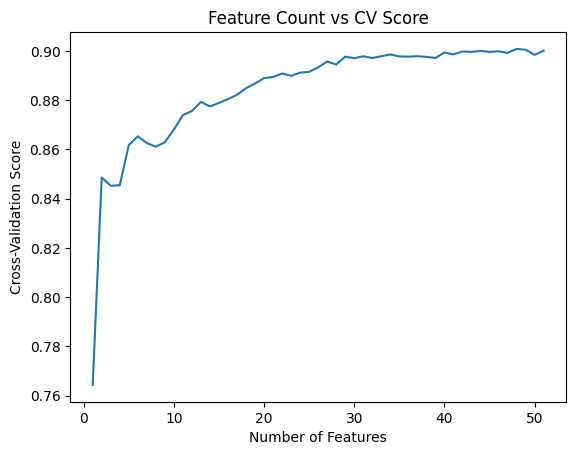

In [12]:
features_df = features_df.sort_values(
    by=["rf_importance", "lasso_coefficients", "rfe_ranking"],
    ascending=[False, False, True],
)

# Use a cross-validation framework to assess models with different numbers of features, sorted by their importance.
# This approach allows for the selection of the number of features that yields the best cross-validation score.

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
clf = RandomForestClassifier()

# Stores the mean cross-validation scores
cv_scores = []

# Loop over the number of features, incrementally adding one feature at a time based on their importance
for n_features in range(1, len(features_df) + 1):
    # Select the top n_features
    top_features = features_df.head(n_features)["feature"]

    # Train the model using only the top n_features. We need to select the columns from X_train and X_test by using column names, not indices
    X_train_selected = (
        X_train[:, top_features.index]
        if isinstance(X_train, np.ndarray)
        else X_train[top_features.tolist()]
    )
    X_test_selected = (
        X_test[:, top_features.index]
        if isinstance(X_test, np.ndarray)
        else X_test[top_features.tolist()]
    )

    # Perform cross-validation and store the mean score
    scores = cross_val_score(clf, X_train_selected, y_train, cv=5, n_jobs=-1)
    cv_scores.append(scores.mean())

# Find the number of features that maximize the cross-validation score
best_feature_count = np.argmax(cv_scores) + 1  # Adding 1 because index starts at 0
best_cv_score = cv_scores[best_feature_count - 1]

print(
    f"Best number of features: {best_feature_count} with cross-validation score: {best_cv_score}"
)

# Plot the relationship between the number of features and cross-validation score
plt.plot(range(1, len(features_df) + 1), cv_scores)
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score")
plt.title("Feature Count vs CV Score")
plt.show()

In [13]:
# Select the top 'best_feature_count' features
top_features = features_df.head(best_feature_count)["feature"]

# Update X_train and X_test to include only the selected features
X_train_selected = X_train[:, top_features.index] if isinstance(X_train, np.ndarray) else X_train[top_features.tolist()]
X_test_selected = X_test[:, top_features.index] if isinstance(X_test, np.ndarray) else X_test[top_features.tolist()]
X_pred_selected =X_pred[:, top_features.index] if isinstance(X_pred, np.ndarray) else X_pred[top_features.tolist()]
top_features

9                                log_BMI
2                                 Weight
21                            log_Weight
25             Height_Weight_interaction
13                                   BMR
18               overall_lifestyle_score
20                            log_Height
1                                 Height
28                           Gender_Male
12                  healthy_eating_score
19                               log_Age
0                                    Age
3                                   FCVC
27                         Gender_Female
22                             sqrt_FCVC
26                  Age_FCVC_interaction
11               caloric_intake_tendency
16               stress_eating_indicator
10               physical_activity_score
24                             sqrt_CH2O
8                                    TUE
6                                   CH2O
7                                    FAF
4                                    NCP
23              

In [14]:
X_train_selected,X_test_selected,X_pred_selected

(array([[ 0.9455362 ,  0.63168979,  0.69528455, ...,  0.10928832,
         -0.10928832, -0.05920266],
        [-1.93215654, -1.74211735, -2.15531397, ...,  0.10928832,
         -0.10928832, -0.05920266],
        [-1.126183  , -1.40388201, -1.55785655, ...,  0.10928832,
         -0.10928832, -0.05920266],
        ...,
        [-0.00592267, -0.34024149, -0.18747383, ...,  0.10928832,
         -0.10928832, -0.05920266],
        [ 1.17043942,  0.9068754 ,  0.90637941, ...,  0.10928832,
         -0.10928832, -0.05920266],
        [-1.45793873, -1.25193337, -1.32210838, ...,  0.10928832,
         -0.10928832, -0.05920266]]),
 array([[ 1.19697271,  0.91079009,  0.90928358, ...,  0.10928832,
         -0.10928832, -0.05920266],
        [-0.36771181, -0.30225433, -0.14795599, ...,  0.10928832,
         -0.10928832, -0.05920266],
        [-0.02470158, -0.12287052,  0.032297  , ...,  0.10928832,
         -0.10928832, -0.05920266],
        ...,
        [ 0.21517527, -0.22628   , -0.07036326, ...,  

### Model selection

In [15]:
from sklearn.impute import SimpleImputer

# Apply imputation to handle NaN values in training data
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Defining a dictionary to hold model configurations.
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Trees": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting Machines": GradientBoostingClassifier(random_state=42),
    "Support Vector Machines": SVC(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbosity = -1),
}

# Function to perform cross-validation and compute mean accuracy and standard deviation.
def cross_val(model, X, y):
    results = cross_validate(model, X, y, cv=5, scoring="accuracy", n_jobs=-1)
    mean_score = results["test_score"].mean()
    std_score = results["test_score"].std()
    return mean_score, std_score


# Function to execute cross-validation for each model in parallel and consolidate the results.
def evaluate_model(name, model, X_train, y_train):
    mean_score, std_score = cross_val(model, X_train, y_train)
    return {"Model": name, "Mean Accuracy": mean_score, "Std Deviation": std_score}


results_list = joblib.Parallel(n_jobs=-1)(
    joblib.delayed(evaluate_model)(name, model, X_train_imputed, y_train) for name, model in models.items()
)

# Creating a DataFrame to store and scrutinize the cross-validation results.
results_df = pd.DataFrame(results_list)

# Sorting the results based on mean accuracy to highlight top-performing models.
results_df = results_df.sort_values(by="Mean Accuracy", ascending=False)

fig = px.bar(results_df, x="Model", y=["Mean Accuracy", "Std Deviation"], title="Model Performance", labels={"value":"Score", "variable":"Metrics"})

fig.show()

/usr/local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

## Hyperparameter tuning, ensembling

In [ ]:
def optimize_model(trial, model_name):
    # Ensembling methods
    from sklearn.ensemble import VotingClassifier
    import os

    # Ensuring TPU usage
    os.environ["XLA_USE_BF16"] = "1"
    os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

    if model_name == "Ensemble":
        lgbm_params = {
            "n_estimators": trial.suggest_int("lgbm_n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("lgbm_max_depth", 3, 50),
            "learning_rate": trial.suggest_float("lgbm_learning_rate", 0.001, 0.1),
            "num_leaves": trial.suggest_int("lgbm_num_leaves", 20, 300),
            "boosting_type": trial.suggest_categorical("lgbm_boosting_type", ["gbdt", "dart"]),
            "min_child_samples": trial.suggest_int("lgbm_min_child_samples", 10, 300),
            "verbosity": (-1),
        }

        xgb_params = {
            "n_estimators": trial.suggest_int("xgb_n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("xgb_max_depth", 3, 50),
            "learning_rate": trial.suggest_float("xgb_learning_rate", 0.001, 0.1),
            "subsample": trial.suggest_float("xgb_subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.6, 1.0),
        }

        rf_params = {
            "n_estimators": trial.suggest_int("rf_n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("rf_max_depth", 3, 50),
            "min_samples_split": trial.suggest_int("rf_min_samples_split", 2, 50),
            "min_samples_leaf": trial.suggest_int("rf_min_samples_leaf", 1, 50),
        }

        lgbm = LGBMClassifier(**lgbm_params, random_state=42)
        xgb = XGBClassifier(**xgb_params, random_state=42)
        rf = RandomForestClassifier(**rf_params, random_state=42)

        ensemble_clf = VotingClassifier(estimators=[
            ('lgbm', lgbm), ('xgb', xgb), ('rf', rf)], voting='soft')

        model = ensemble_clf

    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_val, model.predict(X_val))
    trial.set_user_attr("best_model", model)
    return accuracy


def perform_optimization():
    best_models_params = {}
    study_results = []

    for model_name in ["Ensemble"]:
        study = optuna.create_study(direction="maximize", study_name=f"Optimization for {model_name}")
        optimize_func = lambda trial: optimize_model(trial, model_name)
        study.optimize(optimize_func, n_trials=100, n_jobs=-1)
        best_models_params[model_name] = study.best_params

        # Visualizations of optimization history and parameter importances
        plot_optimization_history_fig = optuna.visualization.plot_optimization_history(study)
        plot_optimization_history_fig.show()

        plot_param_importances_fig = optuna.visualization.plot_param_importances(study)
        plot_param_importances_fig.show()

        # Picking the best model for predictions
        best_model = study.best_trial.user_attrs["best_model"]

        # Prediction with the best model
        y_pred = best_model.predict(X_test)

        # Evaluation of the best model
        print(classification_report(y_test, y_pred))

        # Visualizing the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        fig = px.imshow(cm, text_auto=True, labels={"x": "Predicted", "y": "True", "color": "Number of observations"}, x=[str(x) for x in range(np.max(y_test) + 1)], y=[str(x) for x in range(np.max(y_test) + 1)], title="Confusion Matrix")
        fig.show()

        # Constructing and visualizing the ROC curve
        y_bin = LabelBinarizer().fit_transform(y_test)
        y_pred_prob = best_model.predict_proba(X_test)
        fpr, tpr, roc_auc = {}, {}, {}

        for i in range(len(np.unique(y_test))):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        roc_curve_fig = go.Figure()

        for i in range(len(np.unique(y_test))):
            roc_curve_fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode="lines", name=f"Class {i} (AUC = {roc_auc[i]:.2f})"))

        roc_curve_fig.update_layout(title="ROC Curve and AUC", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate")
        roc_curve_fig.show()

    # Submission creation
    y_pred_sub = best_model.predict(X_pred)
    submission = pd.DataFrame({'id': df_test['id'], 'target': y_pred_sub})
    submission.to_csv('submission.csv', index=False)


    df_results = pd.DataFrame(study_results)

    fig = go.Figure(data=[go.Bar(name="Best Accuracy", x=df_results["Model"], y=df_results["Best Accuracy"], text=df_results["Best Accuracy"], textposition="auto")])
    fig.update_layout(title_text="Comparison of Model Hyperparameter Optimization Results")
    fig.show()

    return best_models_params


best_models_params = perform_optimization()

[I 2024-03-01 05:51:27,783] A new study created in memory with name: Optimization for Ensemble
[I 2024-03-01 06:02:37,632] Trial 32 finished with value: 0.9053468208092486 and parameters: {'lgbm_n_estimators': 412, 'lgbm_max_depth': 3, 'lgbm_learning_rate': 0.002369523193033378, 'lgbm_num_leaves': 242, 'lgbm_boosting_type': 'dart', 'lgbm_min_child_samples': 257, 'xgb_n_estimators': 289, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.0949378274029927, 'xgb_subsample': 0.8882569886363421, 'xgb_colsample_bytree': 0.9558744700031144, 'rf_n_estimators': 207, 'rf_max_depth': 7, 'rf_min_samples_split': 14, 'rf_min_samples_leaf': 41}. Best is trial 32 with value: 0.9053468208092486.
[I 2024-03-01 06:04:45,256] Trial 36 finished with value: 0.894990366088632 and parameters: {'lgbm_n_estimators': 149, 'lgbm_max_depth': 16, 'lgbm_learning_rate': 0.03295104324663167, 'lgbm_num_leaves': 26, 'lgbm_boosting_type': 'dart', 'lgbm_min_child_samples': 29, 'xgb_n_estimators': 154, 'xgb_max_depth': 24, 'xgb_le

### For later usage

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


### PyTorch Tensor creation
train_tensor = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
valid_tensor = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))
test_tensor = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

### dataloaders
train_loader = DataLoader(dataset=train_tensor, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_tensor, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_tensor, batch_size=64, shuffle=False)

### Modell def
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

model = MLP(input_dim=X_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### train
def train_model(num_epochs, model, train_loader, valid_loader):
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
        
            model.eval()
            valid_loss = 0
            with torch.no_grad():
                for X_batch, y_batch in valid_loader:
                    outputs = model(X_batch)
                    loss = criterion(outputs.squeeze(), y_batch)
                    valid_loss += loss.item()
            print(f'Epoch {epoch+1}, Loss: {loss.item()}, Valid Loss: {valid_loss / len(valid_loader)}')

train_model(num_epochs=10, model=model, train_loader=train_loader, valid_loader=valid_loader)

### Tesztelés
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

test_model(model=model, test_loader=test_loader)
